In [7]:
import data_loader
import loss
import solver
import utils
from models import FarSegNet, DFarSegNet
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import torch
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
root_path = '/home/renyan/ossdata/massachusetts-roads-dataset/'
# 5 for dilation, 4 for non-dilation
road_path = root_path + "tiff_select5_parts_16/"
INPUT_SIZE, OUTPUT_SIZE = 256, 256
BATCH_SIZE = 4
LR = 0.0001
EPOCH_NUM = 20

In [3]:
train_dataset = data_loader.RoadDataset(road_path, INPUT_SIZE, OUTPUT_SIZE, 'train')
val_dataset = data_loader.RoadDataset(road_path, INPUT_SIZE, OUTPUT_SIZE, 'val')

train dataset set: 8836 pairs with sample ratio None
val dataset set: 224 pairs with sample ratio None


In [4]:
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True)

In [5]:
img, lbl = next(iter(train_loader))

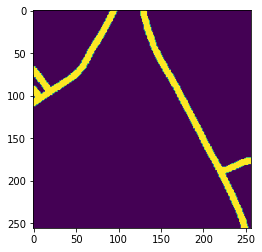

In [8]:
plt.imshow(lbl[0,:,:,:].permute(1, 2, 0))

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = DFarSegNet.DFarSegNet().to(device)
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params = net.parameters(), lr = LR)
writer = SummaryWriter(comment="tensorboard_log{0:%Y-%m-%dT%H-%M-%S/}".format(datetime.now()))

In [77]:
# img, lbl = next(iter(train_dataset))
# img = img.unsqueeze(0).to(device)
# net.eval()
# prob, pred = net(img)
# prob, pred = prob.cpu(), pred.cpu()

In [ ]:
def update_lr_poly(initial_lr, step, max_step, power):
    return initial_lr * (1-step/max_step)**power

In [43]:
global_step = 0
for epoch in range(EPOCH_NUM):
    net.train()
    
    timer, counter = utils.Timer(), utils.Counter()
    timer.start()
    for step, (img, label) in enumerate(train_loader):
        img, label = img.to(device), label.to(device)
        reader_time = timer.elapsed_time()

        loss, miou = net(img, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss = float(loss)
        batch_time = timer.elapsed_time()
        counter.append(loss=loss, miou=miou, reader_time=reader_time, batch_time=batch_time)
        eta = utils.calculate_eta(len(train_loader) - step, counter.batch_time)
        print(f"[epoch={epoch + 1}/{EPOCH_NUM}] "
                  f"step={step + 1}/{len(train_loader)} "
                  f"loss={loss:.4f}/{counter.loss:.4f} "
                  f"miou={miou:.4f}/{counter.miou:.4f} "
                  f"batch_time={counter.batch_time:.4f} "
                  f"reader_time={counter.reader_time:.4f} "
                  f"| ETA {eta}",
                  end="\r",
                  flush=True)
        if global_step % 200 == 0:
            writer.add_scalar("Loss", float(loss), global_step=global_step)
            writer.add_scalar("miou", float(miou), global_step=global_step)
            writer.add_scalar("learning_rate", optimizer.param_groups[0]['lr'], global_step = global_step)
            for tag, value in net.named_parameters():
                tag = tag.replace('.', '/')
                try:
                    writer.add_histogram('weights/' + tag, value.data.cpu().numpy(), global_step)
                    writer.add_histogram('grads/' + tag, value.grad.data.cpu().numpy(), global_step)
                except:
                    pass

            net.eval()
            with torch.no_grad():
                probs, preds = net(img, label)
            writer.add_images('image', img, global_step)
            writer.add_images('label/true', label, global_step)
            writer.add_images('label/pred_0.5', preds, global_step)
            net.train()
        global_step += 1
        writer.flush()
        
    print()
    torch.save(net.state_dict(), 'checkpoints/farseg_retrain_epoch{}_global_step{}.pth'.format(epoch+1, global_step))
    timer.restart()
    optimizer.param_groups[0]['lr'] = update_lr_poly(LR, epoch, EPOCH_NUM, 0.9)

[epoch=1/20] step=2209/2209 loss=0.1078/0.1652 miou=0.4131/0.3417 batch_time=1006.6184 reader_time=1006.3718 | ETA 00:16:46


NameError: name 'update_lr_poly' is not defined